In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from tqdm import tqdm

# Read the CSV file with a different encoding
df = pd.read_csv('/content/drive/MyDrive/Final_Albert/data.csv', names=["sentence", 'sentiment'], encoding='ISO-8859-1')

# Define the mapping for sentiment labels
sentiment_map = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}

# Apply the mapping to the 'sentiment' column in the DataFrame
df['sentiment'] = df['sentiment'].map(sentiment_map)

# Drop rows with NaN values in the 'sentiment' column
df = df.dropna(subset=['sentiment'])

# Convert 'sentiment' column to integer type
df['sentiment'] = df['sentiment'].astype(int)


OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\haris\anaconda3\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.loc[idx, 'sentence']
        label = self.dataframe.loc[idx, 'sentiment']
        encoding = self.tokenizer(text,
                                  add_special_tokens=True,
                                  max_length=self.max_len,
                                  truncation=True,
                                  padding='max_length',
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the ALBERT tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
num_classes = len(df['sentiment'].unique())  # Assuming labels are integers
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_classes)

# Define hyperparameters
batch_size = 16
max_len = 128
num_epochs = 4
learning_rate = 1e-5

# Create instances of custom dataset
dataset = CustomDataset(dataframe=df, tokenizer=tokenizer, max_len=max_len)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Define training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batches'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    print(f'Average training loss: {avg_train_loss}')

    # Validation
    model.eval()
    val_loss = 0
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            num_correct += (preds == labels).sum().item()
            num_samples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = num_correct / num_samples
    print(f'Average validation loss: {avg_val_loss}, Validation accuracy: {val_accuracy}')

    # Update the learning rate
    scheduler.step()

print('Training complete!')



Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/4: 100%|██████████| 293/293 [01:37<00:00,  3.00batches/s]


Average training loss: 0.6917184635539104
Average validation loss: 0.48987337816003207, Validation accuracy: 0.7698887938408896


Epoch 2/4: 100%|██████████| 293/293 [01:41<00:00,  2.88batches/s]


Average training loss: 0.38607750518991274
Average validation loss: 0.4577592173842965, Validation accuracy: 0.7835757057313943


Epoch 3/4: 100%|██████████| 293/293 [01:42<00:00,  2.86batches/s]


Average training loss: 0.3489601732431927
Average validation loss: 0.45751958702867096, Validation accuracy: 0.7835757057313943


Epoch 4/4: 100%|██████████| 293/293 [01:42<00:00,  2.85batches/s]


Average training loss: 0.34790530594847713
Average validation loss: 0.4575522004349812, Validation accuracy: 0.7827202737382378
Training complete!


In [7]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/Final_Albert/distilbert_model.pth')

In [9]:

# Inference
from transformers import AlbertTokenizer, AlbertForSequenceClassification

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
num_classes = len(df['sentiment'].unique())  # Assuming labels are integers

model_path = r"/content/drive/MyDrive/Final_Albert/distilbert_model.pth"
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()  # Set the model to evaluation mode


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [10]:
#new_sentence_pos="The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."
new_sentence_pos = "The company reported larger than expected earnings for the quarter, leading to a increase in stock prices."

new_sentence_neg = "The company reported lower than expected earnings for the quarter,leading to huge losses"
#new_sentence_neg = "$ESI on lows, down $1.50 to $2.50 BK a real possibility"

new_sentence_neut = "The company announced its quarterly earnings report."
#new_sentence_neut ="Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares of Ahlstrom Corporation have been subscribed with option rights under the company 's stock option programs I 2001 and II 2001 ."

inputs = tokenizer(new_sentence_neg, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)


0


In [11]:
inputs = tokenizer(new_sentence_pos, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)

2


In [12]:
inputs = tokenizer(new_sentence_neut, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)

1


In [16]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer, pipeline

# Set up the few-shot pipeline
def create_few_shot_pipeline(model):
    # Load the fine-tuned ALBERT model
    tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

    few_shot_pipeline = pipeline(
        task="text-classification",
        model=model,
        tokenizer=tokenizer
    )

    return few_shot_pipeline

# Instantiate the ALBERT model for sequence classification
# model = AlbertForSequenceClassification.from_pretrained('albert-base-v2')

# Create the few-shot pipeline with your fine-tuned ALBERT model
few_shot_pipeline = create_few_shot_pipeline(model)####PFREV FINE TUNED MODEL WILL BE USED

# Define your few-shot texts and labels for training
few_shot_texts = [
    "The GeoSolutions technology will leverage Benefon's GPS solutions by providing Location Based Search Technology, a Communities Platform, location relevant multimedia content and a new and powerful commercial model.",
    "Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares of Ahlstrom Corporation have been subscribed with option rights under the company's stock option programs I 2001 and II 2001.",
    "$ESI on lows, down $1.50 to $2.50 BK a real possibility"
]
few_shot_labels = ["Positive", "Neutral", "Negative"]  # Adjust labels accordingly

#
#########################################################
################ to  stop overfittinng ####################
# ############################################################
# for text, label in zip(few_shot_texts, few_shot_labels):
#     few_shot_pipeline(text)
#
#
#
#
# Ask the user for input and predict
user_input = input("Enter a statement: ")

result = few_shot_pipeline(user_input)

# Extract the predicted label from the result
predicted_label = result[0]['label']
predicted_score = result[0]['score']

print("Predicted label:", predicted_label)
print("Predicted score:", predicted_score)

# Map the internal label indices to the actual labels
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Get the predicted sentiment label
predicted_sentiment = label_map.get(predicted_label, "Unknown")
print("Predicted sentiment:", predicted_sentiment)


Enter a statement: it was  a huge loss
Predicted label: LABEL_0
Predicted score: 0.5710006952285767
Predicted sentiment: Negative


In [20]:
# Define the path to save the model (including the filename with the .pth extension)
save_model_path = "/content/drive/MyDrive/Final_Albert/fewshoted_model.pth"

# Save the model's state_dict() to a .pth file
torch.save(model.state_dict(), save_model_path)


In [21]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')  # Use ALBERT tokenizer
num_classes = len(df['sentiment'].unique())  # Assuming labels are integers

model_path = '/content/drive/MyDrive/Final_Albert/fewshoted_model.pth'
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_classes)  # Initialize ALBERT model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()  # Set the model to evaluation mode


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [22]:
import pandas as pd

# Define a list to store data
data = []

# Evaluate the model on the validation dataset and store data
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Assuming labels are also tensors

        # Move model to the same device as input tensors
        model = model.to(device)

        # Make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        # Append data to the list
        for i, label in enumerate(labels):  # Iterate over labels directly
            true_label = label.item()
            predicted_label = preds[i].item()
            data.append((true_label, predicted_label))

# Create a DataFrame
df_validation = pd.DataFrame(data, columns=['True Label', 'Predicted Label'])

# Display the DataFrame
print(df_validation)

# Save the DataFrame to a CSV file
df_validation.to_csv('your_file.csv', index=False)  # index=False prevents writing row indices


      True Label  Predicted Label
0              2                2
1              0                0
2              1                0
3              0                2
4              1                2
...          ...              ...
1164           2                2
1165           1                2
1166           0                2
1167           0                0
1168           2                2

[1169 rows x 2 columns]


In [32]:
import os

# Define the directory where you want to save the CSV file
save_directory = '/content/drive/MyDrive/Final_Albert'

# Ensure the directory exists, create it if necessary
os.makedirs(save_directory, exist_ok=True)

# Define the file path
csv_file_path = os.path.join(save_directory, 'your_file.csv')

# Save the DataFrame to a CSV file
df_validation.to_csv(csv_file_path, index=False)  # index=False prevents writing row indices

print(f"CSV file saved to: {csv_file_path}")


CSV file saved to: /content/drive/MyDrive/Final_Albert/your_file.csv


In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# Assuming you have loaded your dataset into a pandas DataFrame
# Replace 'data.csv' with the path to your actual dataset
df = pd.read_csv(r"/content/drive/MyDrive/Final_Albert/your_file.csv")

# Extract true labels and predicted labels from the DataFrame
true_labels = df['True Label']
predicted_labels = df['Predicted Label']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-score:", f1)




Accuracy: 0.2643284858853721
Precision: 0.42125851515399776
Recall: 0.2643284858853721
F1-score: 0.19777588245254898


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix


# Extract true labels and predicted labels from the DataFrame
true_labels = df['True Label']
predicted_labels = df['Predicted Label']

# Get unique labels
labels = sorted(set(true_labels) | set(predicted_labels))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Create a DataFrame for the confusion matrix with headers
confusion_df = pd.DataFrame(conf_matrix, index=['Actual ' + str(label) for label in labels], columns=['Predicted ' + str(label) for label in labels])
print("Confusion Matrix:")
print(confusion_df)


Confusion Matrix:
          Predicted 0  Predicted 1  Predicted 2
Actual 0           64            7          133
Actual 1          284           13          293
Actual 2          140            3          232


In [4]:
# Calculate the index for the positive class
positive_class_index = labels.index(2)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for +ve class:", accuracy_positive)
print("Recall for +ve class:", recall_positive)
print("Precision for +ve class:", precision_positive)
print("F1-score for +ve class:", f1_positive)


Accuracy for +ve class: 0.5132591958939264
Recall for +ve class: 0.6186666666666667
Precision for +ve class: 0.3525835866261398
F1-score for +ve class: 0.4491771539206196


In [37]:
# Calculate the index for the positive class (class 1)
positive_class_index = labels.index(1)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive

# Calculate true negatives for the positive class (considering classes 0 and 2 as negative)
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for neutral class (1):", accuracy_positive)
print("Recall for neutral class (1):", recall_positive)
print("Precision for neutral class (1):", precision_positive)
print("F1-score for neutral class (1):", f1_positive)


Accuracy for neutral class (1): 0.49786142001710865
Recall for neutral class (1): 0.022033898305084745
Precision for neutral class (1): 0.5652173913043478
F1-score for neutral class (1): 0.04241435562805873


In [38]:
# Calculate the index for the positive class (class 0)
positive_class_index = labels.index(0)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive

# Calculate true negatives for the positive class (considering classes 1 and 2 as negative)
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for class :", accuracy_positive)
print("Recall for class :", recall_positive)
print("Precision for class :", precision_positive)
print("F1-score for class 0 :", f1_positive)


Accuracy for class : 0.5175363558597091
Recall for class : 0.3137254901960784
Precision for class : 0.13114754098360656
F1-score for class 0 : 0.18497109826589594


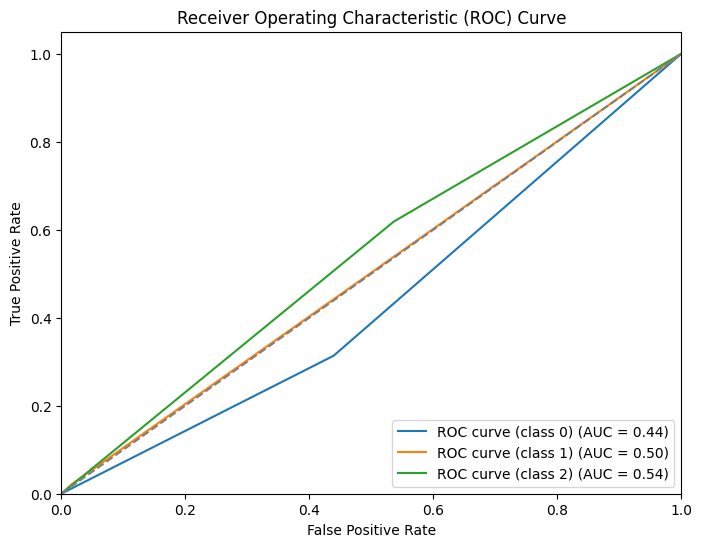

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute the ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_labels == i)
    roc_auc[i] = roc_auc_score(true_labels == i, predicted_labels == i)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



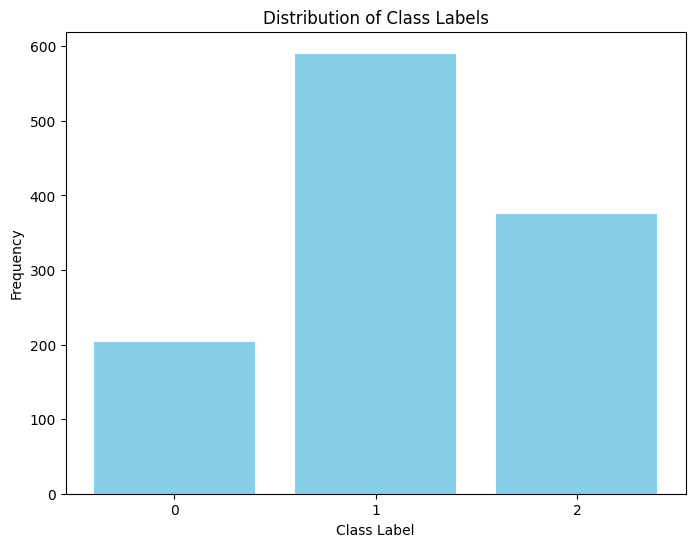

In [40]:
import matplotlib.pyplot as plt

# Count the frequency of each class label
label_counts = df['True Label'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels')
plt.xticks(label_counts.index)  # Ensure all class labels are shown on the x-axis
plt.show()


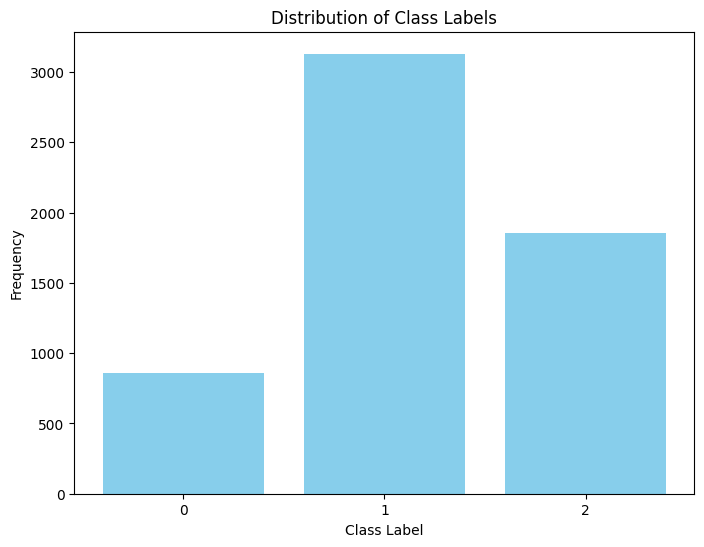

In [42]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Read the CSV file with a different encoding
dff = pd.read_csv(r"/content/drive/MyDrive/Final_Albert/data.csv", names=["sentence", 'sentiment'], encoding='ISO-8859-1')

# Define the mapping for sentiment labels
sentiment_map = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}
dff['sentiment'] = dff['sentiment'].map(sentiment_map)

# Drop rows with NaN values in the 'sentiment' column
dff = dff.dropna(subset=['sentiment'])

# Apply the mapping to the 'sentiment' column in the DataFrame
dff['sentiment'] = dff['sentiment'].astype(int)


label_counts = dff['sentiment'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels')
plt.xticks(label_counts.index)  # Ensure all class labels are shown on the x-axis
plt.show()
